# 隨機森林回歸(Random Forest Regressor)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
from random import choices
import matplotlib.pyplot as plt

# Training Data

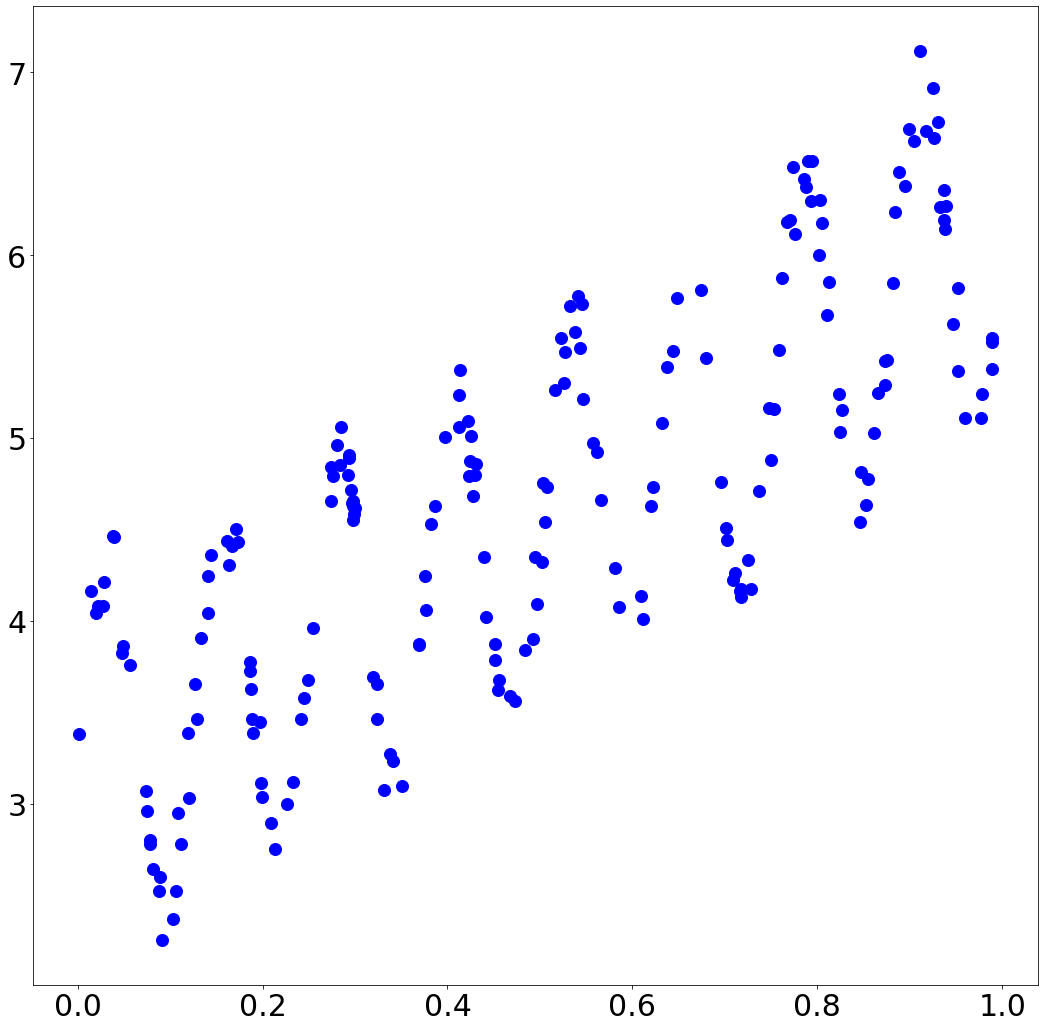

In [2]:
"""
產生我們的訓練集資料
這裡我們使用二次函數+sin函數
"""
p2,p1,p0=1,2,3
x=np.zeros(200)
y=np.zeros(200)
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*0.5
power=[p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
y+=np.sin(x*50)
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"bo",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
x_test=np.zeros(20)
y_test=np.zeros(20)
for i in range(0,len(x_test)):
    x_test[i]+=random.random()
    y_test[i]+=random.random()*0.5
power=[p2,p1,p0]
for i in range(0,len(power)):
    y_test+=power[len(power)-i-1]*(x_test**i)
y_test+=np.sin(x_test*50)

# Plot Decision Line

In [4]:
def plot_line(x_split,y_left_mean,y_right_mean,x_lim,color,sel):
    """
    x_split:縱回歸線的x軸位置 / 左橫回歸線的x軸最大值 / 右橫回歸線的x軸最小值
    y_left_mean：縱回歸線的y軸最小值 / 左橫回歸線的y軸位置
    y_right_mean：縱回歸線的y軸最大值 / 右橫回歸線的y軸位置
    xlim[0]: 左橫回歸線的x軸最小值
    xlim[1]: 右橫回歸線的x軸最大值
    <Condiction>
    (sel==0)
    -->代表當前Node底下的兩個subtree都完美回歸MSE=0，或是已達到所限制的最大層數
       所以我們畫出左右兩邊的橫回歸線和中間的縱回歸線
    (sel==1)
    -->代表當前Node底下的兩個subtree都還沒分完
       所以我們只畫出中間的縱回歸線
    (sel==2)
    -->代表當前Node底下，右邊的subtree已完美回歸MSE=0，但是左邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    (sel==3)
    -->代表當前Node底下，左邊的subtree已完美回歸MSE=0，但是右邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    """
    if(sel==0):
        plt.plot([x_split,x_split],[y_left_mean,y_right_mean],color,linewidth=3)
        plt.plot([x_lim[0],x_split],[y_left_mean,y_left_mean],color,linewidth=3)
        plt.plot([x_split,x_lim[1]],[y_right_mean,y_right_mean],color,linewidth=3)
    elif(sel==1):
        plt.plot([x_split,x_split],[y_left_mean,y_right_mean],color,linewidth=3)
    elif(sel==2):
        plt.plot([x_split,x_lim[1]],[y_right_mean,y_right_mean],color,linewidth=3)
    elif(sel==3):
        plt.plot([x_lim[0],x_split],[y_left_mean,y_left_mean],color,linewidth=3)

# Mean Square Error

In [5]:
def MSE(s,y):
    com=sum((y[s]-np.mean(y[s]))**2)
    return com

# Decision Stump

In [6]:
def Decision_Stump(x,y):
    """
    先將輸入資料x由小到大排序，然後開始將資料分成左右兩邊，找出MSE最小的切割點
    """
    impurity=np.zeros(len(y)-1)
    x_sort=np.sort(x)
    x_sort_index=np.argsort(x)
    for i in range(1,len(y)):
        s_left,s_right=x_sort_index[:i],x_sort_index[i:]
        impurity[i-1]=(len(s_left)/len(y))*MSE(s_left,y)+(len(s_right)/len(y))*MSE(s_right,y)
    x_split=(x_sort[np.argmin(impurity)]+x_sort[np.argmin(impurity)+1])/2
    return x_split,min(impurity)

# Decision Tree Algorithms

In [7]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,x_lim,y_train,y_pred,color):
    """
    x: 輸入訓練資料(隨機取樣的數據)
    y: 輸出訓練資料(隨機取樣的數據)
    x_real: 輸入訓練資料(真實數據)
    y_real: 輸出訓練資料(真實數據)
    x_test: 輸入測試資料
    y_test: 輸出測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    x_lim: 用來畫分割區域的座標
    y_train: 於訓練集所預測的輸出值
    y_pred: 於測試集所預測的輸出值
    color: 回歸線的顏色
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,impurity=Decision_Stump(x,y)
    p=x<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    """
    接著我們一樣以x_split，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=x_real<x_split
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=x_test<x_split
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    而在這邊我們設定劃出回歸線的邊界
    其中x_lim_left和x_lim_right分別代表左邊和右邊subtree的x軸區域邊界
    """
    x_lim_left=np.zeros(2)
    x_lim_right=np.zeros(2)
    x_lim_left[0],x_lim_left[1]=x_lim[0],x_split
    x_lim_right[0],x_lim_right[1]=x_split,x_lim[1]
    """
    檢查左右兩邊的subtree是否只剩下一筆或是輸出資料y都相同
    """
    check_left,check_right=True,True
    if(len(y_left)!=1):
        for i in range(1,len(y_left)):
            if(y_left[i]!=y_left[0]):
                check_left=False
                break
    if(len(y_right)!=1):
        for i in range(1,len(y_right)):
            if(y_right[i]!=y_right[0]):
                check_right=False
                break
    """
    <Condiction>
    (sel==0)
    -->代表當前Node底下的兩個subtree都完美回歸MSE=0，或是已達到所限制的最大層數
       所以我們畫出左右兩邊的橫回歸線和中間的縱回歸線
    (sel==1)
    -->代表當前Node底下的兩個subtree都還沒分完
       所以我們只畫出中間的縱回歸線
    (sel==2)
    -->代表當前Node底下，右邊的subtree已完美回歸MSE=0，但是左邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    (sel==3)
    -->代表當前Node底下，左邊的subtree已完美回歸MSE=0，但是右邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    """
    if((impurity==0)or(max_depth==0)or((check_left)and(check_right))):
        plot_line(x_split,np.mean(y_left),np.mean(y_right),x_lim,color,0)
        y_train[left_index],y_train[right_index]=np.mean(y_left),np.mean(y_right)
        y_pred[left_index_test],y_pred[right_index_test]=np.mean(y_left),np.mean(y_right)
        return np.mean(y_left),np.mean(y_right),y_train,y_pred
    elif(check_left):
        max_depth-=1
        right_y_left,right_y_right,y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,
                                                                x_test,y_test,right_index,right_index_test,
                                                                max_depth,x_lim_right,y_train,y_pred,color)
        plot_line(x_split,np.mean(y_left),right_y_left,x_lim,color,1)
        plot_line(x_split,np.mean(y_left),right_y_left,x_lim,color,3)
        y_train[left_index]=np.mean(y_left)
        y_pred[left_index_test]=np.mean(y_left)
        return np.mean(y_left),right_y_right,y_train,y_pred
    elif(check_right):
        max_depth-=1
        left_y_left,left_y_right,y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,
                                                              x_test,y_test,left_index,left_index_test,
                                                              max_depth,x_lim_left,y_train,y_pred,color)
        plot_line(x_split,left_y_right,np.mean(y_right),x_lim,color,1)
        plot_line(x_split,left_y_right,np.mean(y_right),x_lim,color,2)
        y_train[right_index]=np.mean(y_right)
        y_pred[right_index_test]=np.mean(y_right)
        return left_y_left,np.mean(y_right),y_train,y_pred
    else:
        max_depth-=1
        left_y_left,left_y_right,y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,
                                                              x_test,y_test,left_index,left_index_test,
                                                              max_depth,x_lim_left,y_train,y_pred,color)
        right_y_left,right_y_right,y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,
                                                                x_test,y_test,right_index,right_index_test,
                                                                max_depth,x_lim_right,y_train,y_pred,color)
        plot_line(x_split,left_y_right,right_y_left,x_lim,color,1)
        return left_y_left,right_y_right,y_train,y_pred

# Decision Tree Regressor

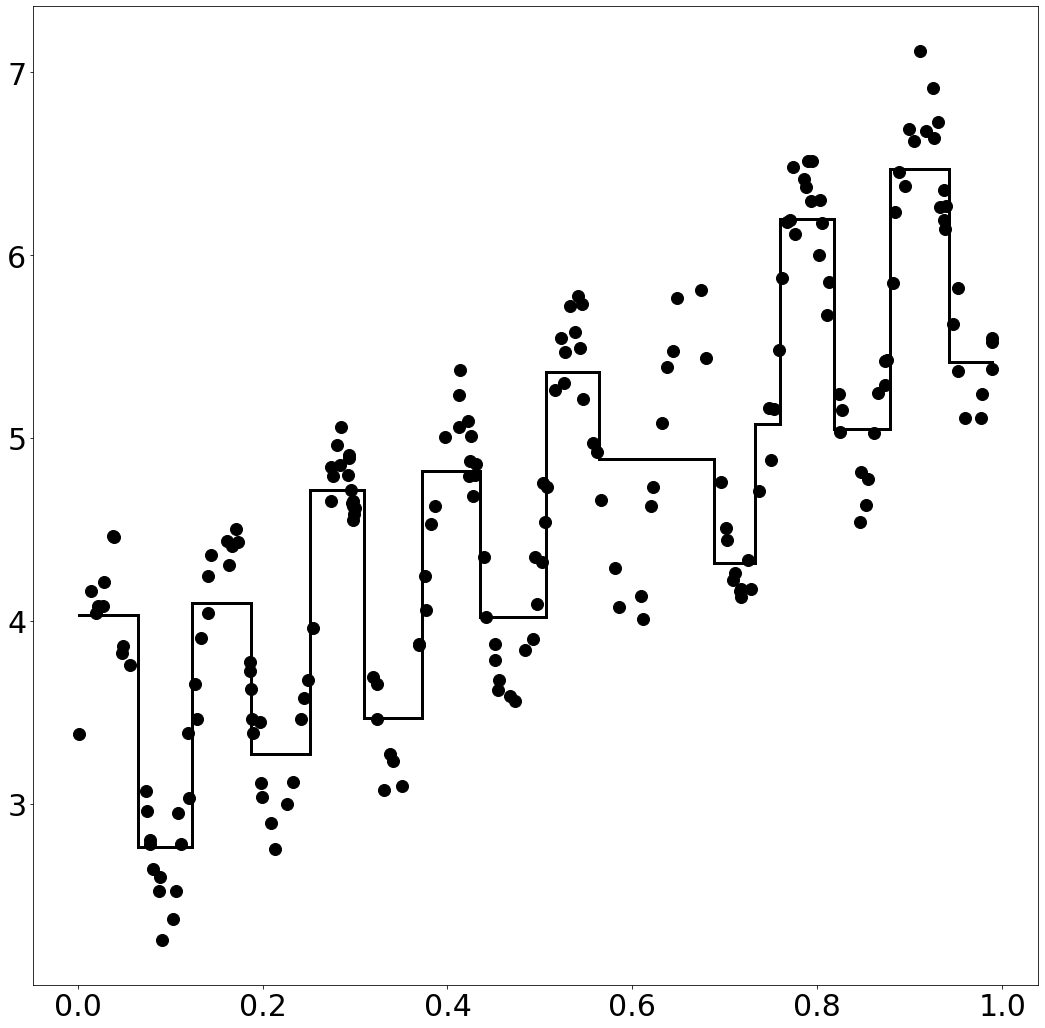

------------------------------------Decision Tree------------------------------------
The Decision Tree Training MSE: 0.10594316426832184  / Testing MSE: 0.17737241931103648


In [8]:
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=12)
x_lim=np.zeros(2)
x_lim[0],x_lim[1]=min(x),max(x)
y_train_DT=np.zeros(len(y))
y_pred_DT=np.zeros(len(y_test))
depth=3
L,R,y_train_DT,y_pred_DT=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),
                                       depth,x_lim,y_train_DT,y_pred_DT,"k")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()
"""
Decision Tree
"""
print("------------------------------------Decision Tree------------------------------------")
print("The Decision Tree Training MSE:",sum((y-y_train_DT)**2)/len(y),
      " / Testing MSE:",sum((y_test-y_pred_DT)**2)/len(y_test))

# Random Forest

------------------------------------Random Forest------------------------------------
The 1 iteration: Decision Tree training MSE =  0.174255 testing MSE =  0.113006
The 2 iteration: Decision Tree training MSE =  0.202728 testing MSE =  0.285589
The 3 iteration: Decision Tree training MSE =  0.121983 testing MSE =  0.126979
The 4 iteration: Decision Tree training MSE =  0.130707 testing MSE =  0.155055
The 5 iteration: Decision Tree training MSE =  0.139812 testing MSE =  0.150085
The 6 iteration: Decision Tree training MSE =  0.204953 testing MSE =  0.199299
The 7 iteration: Decision Tree training MSE =  0.168215 testing MSE =  0.18432
The 8 iteration: Decision Tree training MSE =  0.130343 testing MSE =  0.208627
The 9 iteration: Decision Tree training MSE =  0.216329 testing MSE =  0.377646
The 10 iteration: Decision Tree training MSE =  0.176124 testing MSE =  0.244656
The 11 iteration: Decision Tree training MSE =  0.160424 testing MSE =  0.161229
The 12 iteration: Decision Tree t

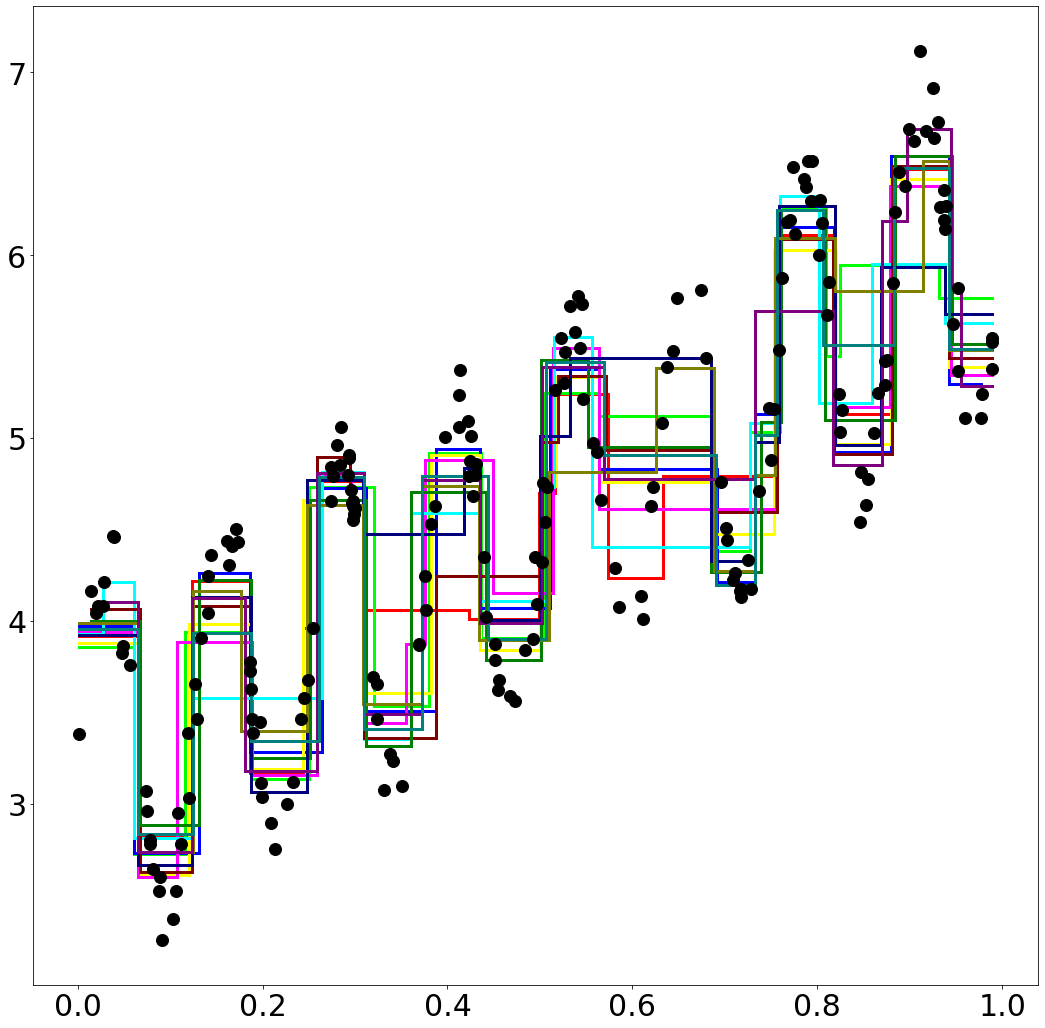

In [9]:
T=12
y_train=np.zeros((len(y),T))
y_pred=np.zeros((len(y_test),T))
color=["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF",
       "#7F0000","#007F00","#00007F","#7F7F00","#7F007F","#007F7F"]
print("------------------------------------Random Forest------------------------------------")
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,T):
    seed=choices(range(0,len(y)), k=len(y))
    x_lim[0],x_lim[1]=min(x[seed]),max(x[seed])
    L,R,y_train[:,i],y_pred[:,i]=Decision_Tree(x[seed],y[seed],x,y,x_test,y_test,
                                               np.where(y),np.where(y_test),
                                               depth,x_lim,y_train[:,i],y_pred[:,i],color[i])
    print("The",i+1,"iteration: Decision Tree training MSE = ",round(sum((y-y_train[:,i])**2)/len(y),6),
          "testing MSE = ",round(sum((y_test-y_pred[:,i])**2)/len(y_test),6))
print("The Random Forest training MSE",round(sum((y-np.sum(y_train,axis=1)/T)**2)/len(y),6),
      "testing MSE",round(sum((y_test-np.sum(y_pred,axis=1)/T)**2)/len(y_test),6))
plt.plot(x,y,"ko",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()    